In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda:1")

### Data

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

data_path = '../Datasets/mnist/'
dataset = datasets.MNIST(data_path, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(data_path, train=False, transform=transform, download=True)

train_loader = DataLoader(dataset, batch_size=100, num_workers=4)

### Model

In [5]:
from cebm.network.network import _cnn, build_decoder, Reshape


class P(nn.Module):
    def __init__(self):
        super().__init__()
        channels = [32,32,64,64]
        num_neurons = [128]
        kernels = [3,4,4,4]
        strides = [1,2,2,2]
        paddings = [3,1,1,1]
        activation = 'SiLU'

        enc, _ = _cnn(28, 28, 1, channels=channels, num_neurons=num_neurons, kernels=kernels, strides=strides, paddings=paddings, activation=activation)
        self.enc = nn.Sequential(enc, nn.Linear(128, 1))
        
    def forward(self, x):
        return self.enc(x).squeeze()
    
class Q(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.logsigma_qx = nn.Parameter((torch.ones(1, ) * .01).log())
        self.logsigma_xiz = nn.Parameter((torch.ones(128,) * .1).log())
        self.gen = nn.Sequential(
                        Reshape((128,1,1)),
                        nn.ConvTranspose2d(128, 128, 2, 1, 0, bias=False), nn.BatchNorm2d(128), nn.SiLU(True),
                        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.SiLU(True),
                        nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.SiLU(True),
                        nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False), nn.BatchNorm2d(32), nn.SiLU(True),
                        nn.ConvTranspose2d(32, 1, 4, 2, 3), nn.Tanh()
                    )
#         gen = build_decoder(p.enc[0]) 
#         gen = gen[1:] + [nn.Sigmoid()]
#         pre_gen = [Reshape((128, 1, 1)), nn.ConvTranspose2d(128, 64, 2, 1, 0), nn.SiLU(inplace=True)]
#         gen = nn.Sequential(*(pre_gen + gen[3:]))
#         self.gen = gen
        
    def forward(self, z):
        return self.gen(z)

In [6]:
p = P()
q = Q(p)

p = p.to(device)
q = q.to(device)

In [7]:
q(torch.randn(10,128).to(device)).shape

torch.Size([10, 1, 28, 28])

In [7]:
pre_q = [Reshape((128, 1, 1)), nn.ConvTranspose2d(128, 64, 4, 2, 0)]
pre_q = nn.Sequential(*pre_q).to(device)
# post_q = nn.Sequential(nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.SiLU(),
#                        nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.SiLU(),
#                        nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.SiLU(),
#                        nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()).to(device)
post_q = nn.Tanh().to(device)

# test_q = nn.Sequential(pre_q, q.gen[3:])
test_q = nn.Sequential(pre_q, q.gen[3:-1], post_q)
# test_q = nn.Sequential(pre_q, q.gen[3:-2], post_q)
# test_q = nn.Sequential(pre_q, post_q)

### Optimizers

In [7]:
optim_logsigma_xiz = torch.optim.Adam([q.logsigma_xiz], lr=2e-4)
optim_p = torch.optim.Adam(p.parameters(), lr=1e-4, betas=(0., 0.9))
optim_q = torch.optim.Adam([q.logsigma_qx] + list(q.gen.parameters()), lr=2e-4, betas=(0., 0.9))

lr_scheduler_p = torch.optim.lr_scheduler.MultiStepLR(optim_p, gamma=0.1, milestones=[130,180])
lr_scheduler_q = torch.optim.lr_scheduler.MultiStepLR(optim_q, gamma=0.1, milestones=[130,180])

### Objective

In [8]:
import torch.distributions as D

def update(x):
    x.requires_grad_()
    
    B = x.shape[0]
    S = 20
    
    # sample z ~ q(z)
    z0 = torch.randn(B, 128).to(device)
    
    # sample x ~ q(x|z0)
    x_q_z0 = D.Normal(q(z0), q.logsigma_qx.exp()).rsample()  # (B, 1, 28, 28)
    # x_q_z0 = x_q_z0.detach().requires_grad_()
    
    energy_x_data = p(x)
    energy_x_q = p(x_q_z0.detach())
    
    norm_grad_energy_xd = torch.autograd.grad(-energy_x_data.sum(), x, create_graph=True)[0].flatten(start_dim=1).norm(2, 1)
    
    # p loss
    gamma = 0.1
    # breakpoint()
    p_loss = (energy_x_data - energy_x_q).mean() + gamma * (norm_grad_energy_xd ** 2. / 2.).mean() 
    # p_loss = p_loss.mean()
    
    optim_p.zero_grad()
    p_loss.backward()
    optim_p.step()
    
    ####################################################
    # xi(z|z0)
    xi_z_z0 = D.Normal(z0, q.logsigma_xiz.exp())
    
    # sample z ~ xi(z|z0)
    z = xi_z_z0.rsample() # (B, 128)
    
    # get decoder means
    x_q_z = q(z)
    
    # distributions in q 
    q_x_z = D.Normal(x_q_z, q.logsigma_qx.exp())
    q_z = D.Normal(0, 1)
    
    # elbo for logsigma_xiz
    # breakpoint()
    elbo = q_x_z.log_prob(x_q_z0).sum([1,2,3]) + q_z.log_prob(z).sum(1) + xi_z_z0.entropy().sum(1)
    logsigma_loss = -elbo.mean()
    
    optim_logsigma_xiz.zero_grad()
    logsigma_loss.backward()
    optim_logsigma_xiz.step()
    
    ######################################################
    # sample zgrad_phi x ~ xi(z|z0)
    z = xi_z_z0.sample(sample_shape=(S,)) # (S, B, 128)
    
    x_q_z0 = D.Normal(q(z0), q.logsigma_qx.exp()).rsample()  # (B, 1, 28, 28)
    
    # get decoder means
    x_q_z = q(z).view(S, *x_q_z0.shape)
    
    # distributions in q 
    q_x_z = D.Normal(x_q_z, q.logsigma_qx.exp())
    
    # breakpoint()
    log_w = q_x_z.log_prob(x_q_z0).sum([2,3,4]) + q_z.log_prob(z).sum(-1) - xi_z_z0.log_prob(z).sum(-1)
    log_w = log_w - log_w.logsumexp(0) # (S, B)
    
    # grad_x log_qx
    grad_x_log_qx = (x_q_z0[None] - x_q_z) / (q.logsigma_qx.exp() ** 2) # (S, B, 1, 28, 28)
    grad_x_log_qx = (log_w.exp()[:,:,None,None,None] *  grad_x_log_qx).sum(0).detach() # (B, 1, 28, 28)
    
    # grad_phi entropy
    grad_phi_entropy = torch.mul(grad_x_log_qx, x_q_z0).mean(0).sum()
    
    # breakpoint()
    
    energy_x_q = p(x_q_z0)#.detach()#
    q_loss = energy_x_q.mean() - grad_phi_entropy#.detach()
    
#     print(x_q_z0)
    optim_q.zero_grad()
    q_loss.backward()
    optim_q.step()
    
    q.logsigma_qx.data.clamp_(np.log(0.01), np.log(0.3))
    
    return logsigma_loss.item(), p_loss.item(), q_loss.item()

### Train

In [9]:
from tqdm.auto import tqdm
import numpy as np

def epoch(data_loader):
    stats = []
    for x,_ in data_loader:
        stats.append(list(update(x.to(device))))
    return np.array(stats)

def train(data_loader, num_epochs):
    
    pbar = tqdm(range(num_epochs))
    for e in pbar:
        stats = epoch(data_loader)
#         breakpoint()
        stats = stats.mean(0)
#         breakpoint()
        pbar.set_postfix({'elbo': stats[0], 'p_loss': stats[1], 'q_loss': stats[2]})
        
        lr_scheduler_p.step()
        lr_scheduler_q.step()

Replace the Gaussian with Continous Normal

Sample from x~p(x|z) using their thing

In [10]:
E = 200
train(train_loader, E)

  0%|          | 0/200 [00:00<?, ?it/s]

### Eval

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


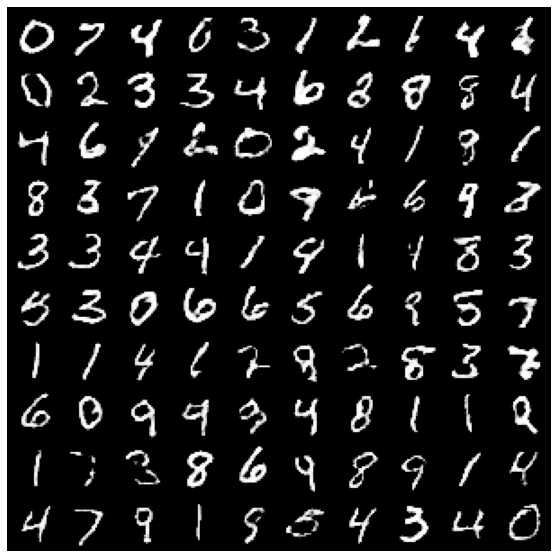

In [73]:
import torchvision
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.gca()

with torch.no_grad():
    z_test = torch.randn(100,128).to(device)
    q_samples = q(z_test).cpu()
    grid = torchvision.utils.make_grid(q_samples, nrow=10)
    ax.imshow(grid.permute(1,2,0))
    ax.axis('off')

In [186]:
import hamiltorch

N = 20000
step_size = 0.00025
L = 10


def log_prob_p(eps):
    return -p(torch.tanh(eps.reshape(1,1,28,28))).sum()
    
# hamiltorch.set_random_seed(123)
# x0 = torch.atanh(q_samples[0].flatten().to(device))
x0 = torch.atanh(2 * torch.rand_like(q_samples[0].flatten().to(device)) - 1.)
p_samples = hamiltorch.sample(log_prob_func=log_prob_p, params_init=x0, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

# burn=500
# N_nuts = burn + N
# p_samples = hamiltorch.sample(log_prob_func=log_prob_p, params_init=x0,
#                                                   num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
#                                                   sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
#                                                   desired_accept_rate=0.8)




Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:19 | 0d:00:00:00 | #################### | 500/500 | 25.45       
Acceptance Rate 1.00


In [174]:
torch.stack(p_samples).cpu().shape

torch.Size([9000, 784])

RuntimeError: operation does not have an identity.

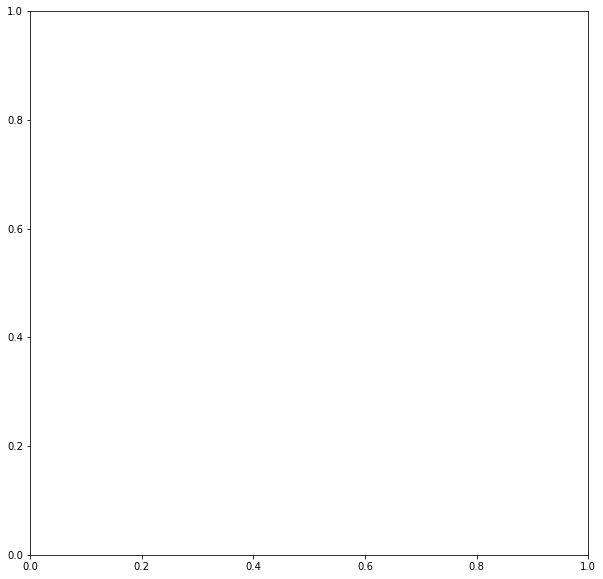

In [187]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

with torch.no_grad():
    n1, n2 = 8900,-1
    p_samples_0 = torch.stack(p_samples).cpu()[n1:n2]
    grid = torchvision.utils.make_grid(p_samples_0.view(-1,1,28,28).tanh(), normalize=True, nrow=10)
    ax.imshow(grid.permute(1,2,0))
    ax.axis('off')

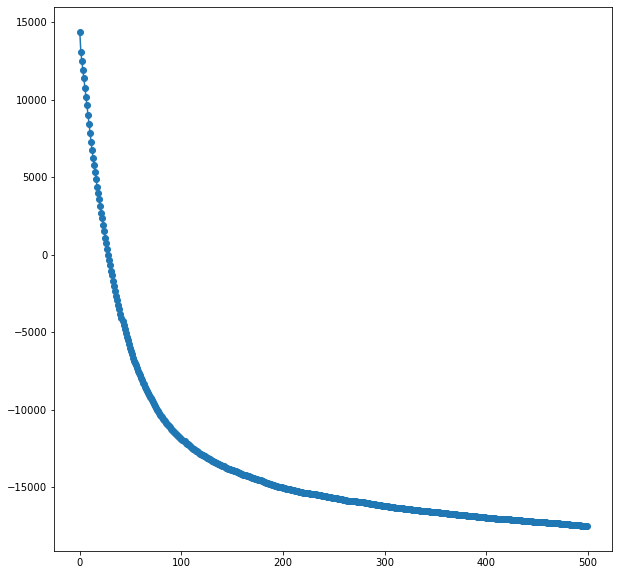

In [188]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
with torch.no_grad():
    ax.plot(p(torch.stack(p_samples).view(-1,1,28,28).tanh().to(device)).cpu(), '-o')

In [189]:
# def norm_im(t):
#     return t.sub(t.min(1)[0][:,None]).div((t.max(1)[0] - t.min(1)[0])[:,None] + 1e-5)

print(p(x0.reshape(-1,1,28,28).tanh()).mean())
print(p(p_samples[-1].view(-1,1,28,28).tanh().to(device)).mean())
p(q_samples.to(device)).mean()

tensor(14390., device='cuda:1', grad_fn=<MeanBackward0>)
tensor(-17528.8691, device='cuda:1', grad_fn=<MeanBackward0>)


tensor(-25019.0586, device='cuda:1', grad_fn=<MeanBackward0>)